# 12 Month EPS Growth Regression Model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Manipulate to get proper monthly EPS growth

Use monthly average PE ratio, average monthly prices, and the 10-Year Treasury Yield to calculate the proper EPS growth

In [2]:
pe_df = pd.read_csv('PE_daily_normalized_tele.csv')

In [3]:
# rename and convert proper types
pe_df = pe_df.rename(columns={"Dates": "Date"})
pe_df['Date']= pd.to_datetime(pe_df['Date'])
pe_df.dtypes

Date    datetime64[ns]
PE             float64
dtype: object

In [4]:
pe_df = pe_df.set_index('Date')
# get average per year, month
pe_df = pe_df.groupby([(pe_df.index.year), (pe_df.index.month)]).PE.mean()
# convert to data frame
pe_df = pd.DataFrame(pe_df)
# rename, reset index
pe_df.index.names=['Year', 'Month']
pe_df =pe_df.reset_index()

In [5]:
pe_df.dtypes

Year     float64
Month    float64
PE       float64
dtype: object

In [6]:
pe_df.head(5)

,Year,Month,PE
0,2001.0,8.0,21.357323
1,2001.0,9.0,21.544017
2,2001.0,10.0,21.277821
3,2001.0,11.0,20.492719
4,2001.0,12.0,20.718582


Load monthly earnings prices

In [7]:
# load average monthly price
avg_m_price = pd.read_csv('daily_price_tele.csv')
# convert proper types
avg_m_price['Dates']= pd.to_datetime(avg_m_price['Dates'])
# check for types
avg_m_price.dtypes

Dates    datetime64[ns]
Value           float64
dtype: object

In [8]:
avg_m_price = avg_m_price.set_index('Dates')
# get average per year, month
avg_m_price = avg_m_price.groupby([(avg_m_price.index.year), (avg_m_price.index.month)]).Value.mean()
# convert to data frame
avg_m_price = pd.DataFrame(avg_m_price)
# rename, reset index
avg_m_price.index.names=['Year', 'Month']
avg_m_price =avg_m_price.reset_index()
# convert proper type
avg_m_price['Month'] = avg_m_price['Month'].astype(int)

In [9]:
avg_m_price.head(5)

,Year,Month,Value
0,2001,8,186.393478
1,2001,9,180.474000
2,2001,10,177.617391
3,2001,11,167.864762
4,2001,12,167.026000


### Join pe and average earnings together

In [10]:
joined = pd.merge(pe_df, avg_m_price,  how='inner', left_on=['Year','Month'], right_on = ['Year', 'Month'])

# get monthly earnings by dividing the two
joined['m_earnings'] = joined['Value']/joined['PE']

# shift monthly earning for later's monthly earning 
joined['prev_m'] = joined['m_earnings'].shift(1)

# calculate monthly EPS growth without subtracting the 10 year yield
joined['EPS_growth'] = ((joined['m_earnings'] - joined['prev_m']) / joined['prev_m'] + 1.0)**12 - 1

In [11]:
joined.head(5)

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth
0,2001.0,8.0,21.357323,186.393478,8.727380,NaN,NaN
1,2001.0,9.0,21.544017,180.474000,8.376989,8.727380,-0.388426
2,2001.0,10.0,21.277821,177.617391,8.347537,8.376989,-0.041385
3,2001.0,11.0,20.492719,167.864762,8.191434,8.347537,-0.202704
4,2001.0,12.0,20.718582,167.026000,8.061652,8.191434,-0.174401


### Load 10-year treasury

In [12]:
treasury = pd.read_csv('mth_treasury_10yr.csv')

# offset by one day to match the proper month later
treasury['DATE'] = pd.to_datetime(treasury['DATE'])
treasury['DATE'] = pd.DatetimeIndex(treasury['DATE'] - pd.DateOffset(1))

# get separate year and month for joining later
treasury['Year'] = pd.DatetimeIndex(treasury.DATE).year
treasury['Month'] = pd.DatetimeIndex(treasury.DATE).month

# divide GS10 by 100 to convert to decimals
treasury['GS10'] = treasury['GS10']/100

In [13]:
treasury.head(5)

,DATE,GS10,Year,Month
0,1953-03-31,0.0283,1953,3
1,1953-04-30,0.0305,1953,4
2,1953-05-31,0.0311,1953,5
3,1953-06-30,0.0293,1953,6
4,1953-07-31,0.0295,1953,7


Join to calculate the final monthly eps growth

In [14]:
new_joined = pd.merge(joined, treasury,  how='inner', left_on=['Year','Month'], right_on = ['Year', 'Month'])

new_joined['final_EPS_growth'] = new_joined['EPS_growth'] - new_joined['GS10']

In [15]:
new_joined.head(5)

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth
0,2001.0,8.0,21.357323,186.393478,8.727380,NaN,NaN,2001-08-31,0.0473,NaN
1,2001.0,9.0,21.544017,180.474000,8.376989,8.727380,-0.388426,2001-09-30,0.0457,-0.434126
2,2001.0,10.0,21.277821,177.617391,8.347537,8.376989,-0.041385,2001-10-31,0.0465,-0.087885
3,2001.0,11.0,20.492719,167.864762,8.191434,8.347537,-0.202704,2001-11-30,0.0509,-0.253604
4,2001.0,12.0,20.718582,167.026000,8.061652,8.191434,-0.174401,2001-12-31,0.0504,-0.224801


In [16]:
# 132 positive growths out of the rest
new_joined[new_joined['final_EPS_growth'] > 0]

,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth
13,2002.0,9.0,31.949121,88.126500,2.758339,2.642938,0.670044,2002-09-30,0.0394,0.630644
14,2002.0,10.0,32.468476,93.917391,2.892572,2.758339,0.768635,2002-10-31,0.0405,0.728135
15,2002.0,11.0,32.885922,109.876000,3.341126,2.892572,4.640329,2002-11-30,0.0403,4.600029
16,2002.0,12.0,27.761554,110.167143,3.968335,3.341126,6.881082,2002-12-31,0.0405,6.840582
19,2003.0,3.0,23.802203,91.600476,3.848403,3.728764,0.460793,2003-03-31,0.0396,0.421193
...,...,...,...,...,...,...,...,...,...,...
225,2020.0,5.0,29.710355,174.436000,5.871219,5.854885,0.033997,2020-05-31,0.0073,0.026697
233,2021.0,1.0,40.843831,220.130526,5.389566,5.376408,0.029766,2021-01-31,0.0126,0.017166
234,2021.0,2.0,41.685345,234.475263,5.624885,5.389566,0.670006,2021-02-28,0.0161,0.653906
235,2021.0,3.0,41.864284,238.392609,5.694415,5.624885,0.158846,2021-03-31,0.0164,0.142446


In [17]:
new_joined.dtypes

Year                       float64
Month                      float64
PE                         float64
Value                      float64
m_earnings                 float64
prev_m                     float64
EPS_growth                 float64
DATE                datetime64[ns]
GS10                       float64
final_EPS_growth           float64
dtype: object

<AxesSubplot:xlabel='DATE'>

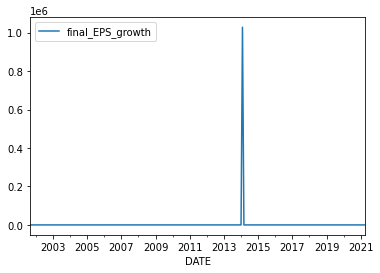

In [18]:
new_joined.loc[1:,['DATE','final_EPS_growth']].set_index('DATE').plot()

In [19]:
new_joined.to_csv('new_joined.csv')

In [20]:
final_df = pd.read_csv('new_joined_cap.csv')

In [21]:
final_df['DATE'] = pd.to_datetime(final_df['DATE'])

<AxesSubplot:xlabel='DATE'>

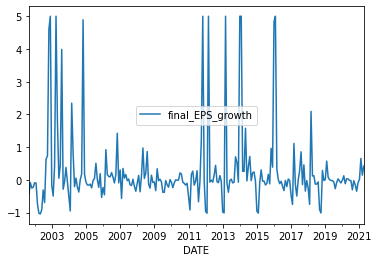

In [22]:
final_df.loc[1:,['DATE','final_EPS_growth']].set_index('DATE').plot()

Create placeholder columns for independent variables


In [23]:
final_df['ppi_cable'] = None
final_df['ppi_wireline'] = None
final_df['ppi_tele_app'] = None
final_df['tele_import'] = None
final_df['tele_export'] = None

Create placeholder columns for dependent variables, which are future 12-month EPS growth rate

In [24]:
final_df['EPS_1'] = None
final_df['EPS_2'] = None
final_df['EPS_3'] = None
final_df['EPS_4'] = None
final_df['EPS_5'] = None
final_df['EPS_6'] = None
final_df['EPS_7'] = None
final_df['EPS_8'] = None
final_df['EPS_9'] = None
final_df['EPS_10'] = None
final_df['EPS_11'] = None
final_df['EPS_12'] = None

In [25]:
# convert to proper types
final_df['EPS_1'] = final_df['EPS_1'].astype(float)
final_df['EPS_2'] = final_df['EPS_2'].astype(float)
final_df['EPS_3'] = final_df['EPS_3'].astype(float)
final_df['EPS_4'] = final_df['EPS_4'].astype(float)
final_df['EPS_5'] = final_df['EPS_5'].astype(float)
final_df['EPS_6'] = final_df['EPS_6'].astype(float)
final_df['EPS_7'] = final_df['EPS_7'].astype(float)
final_df['EPS_8'] = final_df['EPS_8'].astype(float)
final_df['EPS_9'] = final_df['EPS_9'].astype(float)
final_df['EPS_10'] = final_df['EPS_10'].astype(float)
final_df['EPS_11'] = final_df['EPS_11'].astype(float)
final_df['EPS_12'] = final_df['EPS_12'].astype(float)

final_df['ppi_cable'] = final_df['ppi_cable'].astype(float)
final_df['ppi_wireline'] = final_df['ppi_wireline'].astype(float)
final_df['ppi_tele_app'] = final_df['ppi_tele_app'].astype(float)
final_df['tele_import'] = final_df['tele_import'].astype(float)
final_df['tele_export'] = final_df['tele_export'].astype(float)
final_df['final_EPS_growth'] = final_df['final_EPS_growth'].astype(float)

In [26]:
# fill the future 12 monthly eps growths
for index, row in final_df.iterrows():
    if row['DATE'] > pd.Timestamp(year=2020, month=4, day=30, hour=0):
        break
    i = 1
    for i2, row2 in final_df.iterrows():
        if row2['DATE'] > row['DATE']:
            col_name = 'EPS_' + str(i)
            final_df.at[index, col_name] = row2['final_EPS_growth']
            i+=1
            if(i > 12):
                break

In [27]:
final_df

,Unnamed: 0,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
0,0,2001,8,21.357323,186.393478,8.727380,NaN,NaN,2001-08-31,0.0473,...,-0.253604,-0.224801,-0.088894,-0.103775,-0.751221,-1.027059,-1.042693,-0.908506,-0.310953,-0.695266
1,1,2001,9,21.544017,180.474000,8.376989,8.727380,-0.388426,2001-09-30,0.0457,...,-0.224801,-0.088894,-0.103775,-0.751221,-1.027059,-1.042693,-0.908506,-0.310953,-0.695266,0.630644
2,2,2001,10,21.277821,177.617391,8.347537,8.376989,-0.041385,2001-10-31,0.0465,...,-0.088894,-0.103775,-0.751221,-1.027059,-1.042693,-0.908506,-0.310953,-0.695266,0.630644,0.728135
3,3,2001,11,20.492719,167.864762,8.191434,8.347537,-0.202704,2001-11-30,0.0509,...,-0.103775,-0.751221,-1.027059,-1.042693,-0.908506,-0.310953,-0.695266,0.630644,0.728135,4.600029
4,4,2001,12,20.718582,167.026000,8.061652,8.191434,-0.174401,2001-12-31,0.0504,...,-0.751221,-1.027059,-1.042693,-0.908506,-0.310953,-0.695266,0.630644,0.728135,4.600029,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,232,2020,12,40.964319,220.240909,5.376408,5.412921,-0.078009,2020-12-31,0.0108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,233,2021,1,40.843831,220.130526,5.389566,5.376408,0.029766,2021-01-31,0.0126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,234,2021,2,41.685345,234.475263,5.624885,5.389566,0.670006,2021-02-28,0.0161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,235,2021,3,41.864284,238.392609,5.694415,5.624885,0.158846,2021-03-31,0.0164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Load independ variables

Fill in the independent variables by:
- finding the fed/pmi/consumer/bci that is 1) earlier than the timestamp, and 2) second closest to the timestamp

In [44]:
final_df = pd.read_csv('final_df_new.csv')
final_df

FileNotFoundError: [Errno 2] No such file or directory: 'final_df_new.csv'

### Model Logic

**1. Multi-step regression**: Using four predictor variables to predict 12-month ahead EPS growth concurrently 

**2. Target Variable**: For each month, the following 12 month EPS growth data are presented in the same row.

**3. Independent Variables**: We are using information from the past to predict future EPS growth. The independent variables are lagged by one month due to delays in predictor announcement. 



In [38]:
final_df = final_df.dropna()
final_df.tail(15)

,Unnamed: 0,Unnamed: 0.1,Year,Month,PE,Value,m_earnings,prev_m,EPS_growth,DATE,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12


In [39]:
len(final_df)

0

### Modeling regression to predict future 12 monthly EPS growths based on various independent variables

In [40]:
train_X = final_df.iloc[2:172,10:15]
train_y = final_df.iloc[2:172,15::]

In [41]:
train_X

,GS10,final_EPS_growth,ppi_cable,ppi_wireline,ppi_tele_app


<b> Test on the last 24 months </b>

In [34]:
test_X = final_df.iloc[172::,10:15]
test_y = final_df.iloc[172::,15::]

In [35]:
#test_X

In [36]:
# linear regression for multioutput regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
# fit model
linear_regression.fit(train_X, train_y)

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

In [ ]:
yhat = linear_regression.predict(test_X)
# summarize prediction

In [ ]:
from sklearn.metrics import mean_absolute_error
print("Linear Regression MAE")
mean_absolute_error(test_y, yhat)

In [ ]:
# k-nearest neighbors for multioutput regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor

k_n_regressor = KNeighborsRegressor()
# fit model
k_n_regressor.fit(train_X, train_y)

In [ ]:
yhat = k_n_regressor.predict(test_X)
# summarize prediction

In [ ]:
from sklearn.metrics import mean_absolute_error
print("K Neighbor MAE")
mean_absolute_error(test_y, yhat)

In [ ]:
# decision tree for multioutput regression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor()
# fit model
tree_regressor.fit(train_X, train_y)

In [ ]:
yhat = tree_regressor.predict(test_X)
# summarize prediction

In [ ]:
print("Decision Tree MAE")
mean_absolute_error(test_y, yhat)

### Visualize prediction quality

In [ ]:
test_data = final_df.iloc[172::]

In [ ]:
test_data.head(5)

In [ ]:
test_X_1 = final_df.iloc[172:173,10:15]

test_X_2 = final_df.iloc[184:185,10:15]
test_X_2

In [ ]:
yhat_1 = linear_regression.predict(test_X_1)
yhat_2 = linear_regression.predict(test_X_2)

# summarize prediction

In [ ]:
lr_reg_yhat = np.concatenate([yhat_1, yhat_2], axis=1)
lr_reg_yhat

In [ ]:
plot = test_data.loc[:,['DATE','final_EPS_growth']].set_index('DATE')
plot
plot['prediction'] = lr_reg_yhat[0]

In [ ]:
plot.plot()

In [ ]:
yhat_1 = k_n_regressor.predict(test_X_1)
yhat_2 = k_n_regressor.predict(test_X_2)

In [ ]:
k_n_regressor = np.concatenate([yhat_1, yhat_2], axis=1)
plot = test_data.loc[:,['DATE','final_EPS_growth']].set_index('DATE')
plot['prediction'] = k_n_regressor[0]
plot.plot()

In [ ]:
yhat_1 = tree_regressor.predict(test_X_1)
yhat_2 = tree_regressor.predict(test_X_2)

In [ ]:
tree_reg_yhat = np.concatenate([yhat_1, yhat_2], axis=1)
plot = test_data.loc[:,['DATE','final_EPS_growth']].set_index('DATE')
plot['prediction'] = tree_reg_yhat[0]
plot.plot()